In [109]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from transformers import AutoTokenizer, AutoModel
import tqdm.notebook as tq

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [101]:
class PhoBertForMultiLabelClassification(nn.Module):
    def __init__(self):
        super(PhoBertForMultiLabelClassification, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = torch.nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, 10)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.phobert(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [83]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5

In [84]:
class MultiLabelDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [102]:
compare_data = pd.read_excel("compare_data.xlsx").fillna(0)
gpt3_labels = pd.read_excel("gpt3_labels.xlsx").fillna(0)

In [86]:
target_list = list(compare_data.columns)
target_list

['text',
 'view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'none']

In [87]:
target_list = target_list[1:]
target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'none']

In [88]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [89]:
compare_dataset = MultiLabelDataset(compare_data, tokenizer, 128, target_list)
test_data_loader = DataLoader(compare_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

In [90]:
model = PhoBertForMultiLabelClassification()
model.load_state_dict(torch.load("../output/savedmodels/intent_v1.bin"))
model = model.to(device)

In [91]:
def get_predictions(model, data_loader):
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).detach().cpu()
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [116]:
true_labels = compare_data.iloc[:, 1:].values

In [117]:
print(accuracy_score(true_labels, predictions))

0.9084967320261438


In [118]:
print(classification_report(target_values, predictions, target_names=target_list))

                  precision    recall  f1-score   support

       view_menu       0.25      0.20      0.22         5
       view_cart       0.87      0.94      0.91        36
     add_to_cart       0.91      0.99      0.95       347
remove_from_cart       1.00      1.00      1.00        35
modify_cart_item       0.97      0.93      0.95       370
   confirm_order       0.84      0.89      0.86        46
     track_order       0.96      0.80      0.88        61
    cancel_order       0.98      1.00      0.99        40
    provide_info       0.80      1.00      0.89        40
            none       0.92      0.49      0.64        93

       micro avg       0.92      0.91      0.92      1073
       macro avg       0.85      0.83      0.83      1073
    weighted avg       0.93      0.91      0.91      1073
     samples avg       0.91      0.91      0.91      1073



C:\Users\Quoc Toan Tran\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


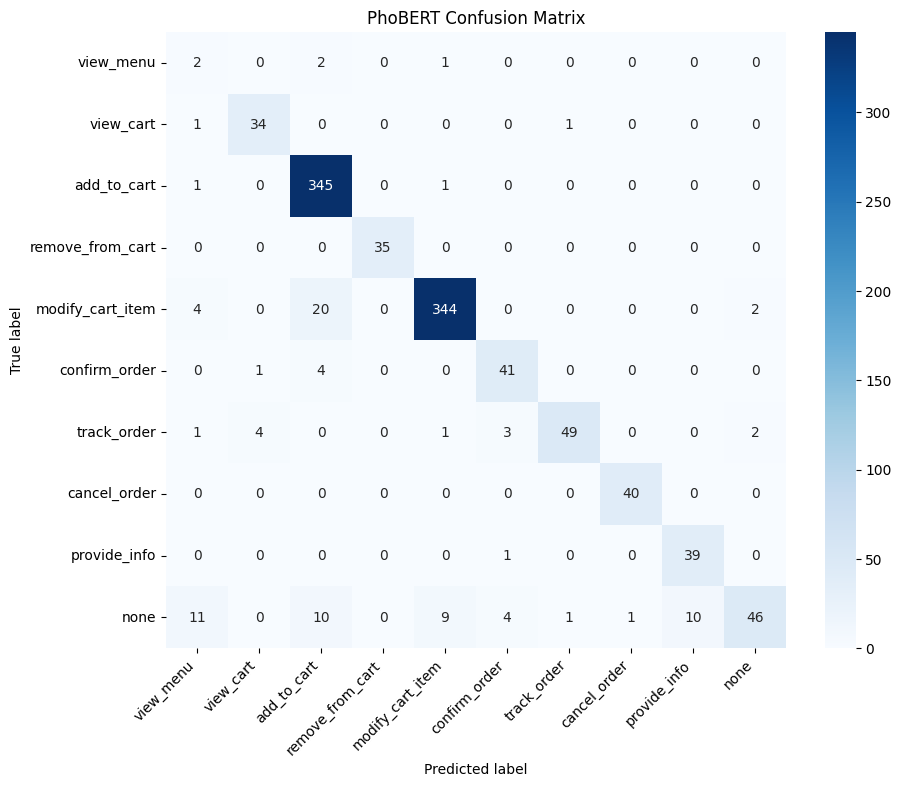

In [119]:
y_pred = predictions.numpy()
y_true = target_values.numpy()

y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_true.argmax(axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

labels = ['view_menu', 'view_cart', 'add_to_cart', 'remove_from_cart', 'modify_cart_item', 
          'confirm_order', 'track_order', 'cancel_order', 'provide_info', 'none']

plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0, va='center')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('PhoBERT Confusion Matrix')
plt.show()

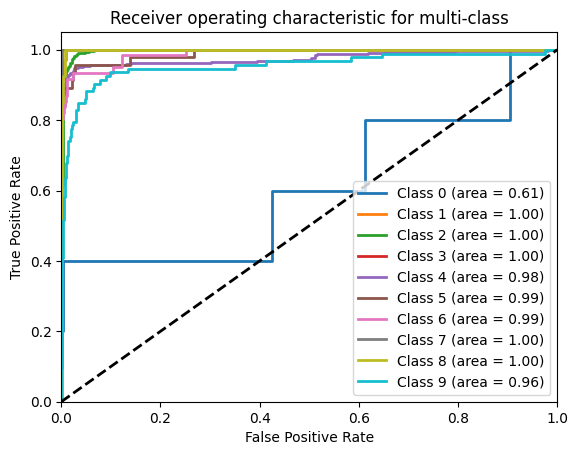

In [120]:
def plot_multiclass_roc_curve(target_values, prediction_probs, n_classes):
    if not isinstance(target_values, np.ndarray):
        target_values = target_values.numpy()
    if not isinstance(prediction_probs, np.ndarray):
        prediction_probs = prediction_probs.numpy()
    
    lw = 2

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(target_values[:, i], prediction_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
                 label='Class {0} (area = {1:0.2f})'.format(i, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()

n_classes = target_values.shape[1]

plot_multiclass_roc_curve(target_values, prediction_probs, n_classes)

In [121]:
gpt3_preds = gpt3_labels.iloc[:, 1:].values 
gpt3_accuracy = accuracy_score(true_labels, gpt3_preds)
gpt3_report = classification_report(true_labels, gpt3_preds, target_names=compare_data.columns[1:])

In [122]:
print(gpt3_accuracy)

0.838468720821662


In [123]:
print(gpt3_report)

                  precision    recall  f1-score   support

       view_menu       0.29      1.00      0.45         5
       view_cart       1.00      1.00      1.00        36
     add_to_cart       0.94      0.87      0.90       347
remove_from_cart       1.00      1.00      1.00        35
modify_cart_item       0.87      0.89      0.88       370
   confirm_order       0.88      0.78      0.83        46
     track_order       0.78      0.92      0.84        61
    cancel_order       0.91      0.97      0.94        40
    provide_info       0.44      0.93      0.60        40
            none       0.59      0.26      0.36        93

       micro avg       0.84      0.84      0.84      1073
       macro avg       0.77      0.86      0.78      1073
    weighted avg       0.85      0.84      0.84      1073
     samples avg       0.84      0.84      0.84      1073



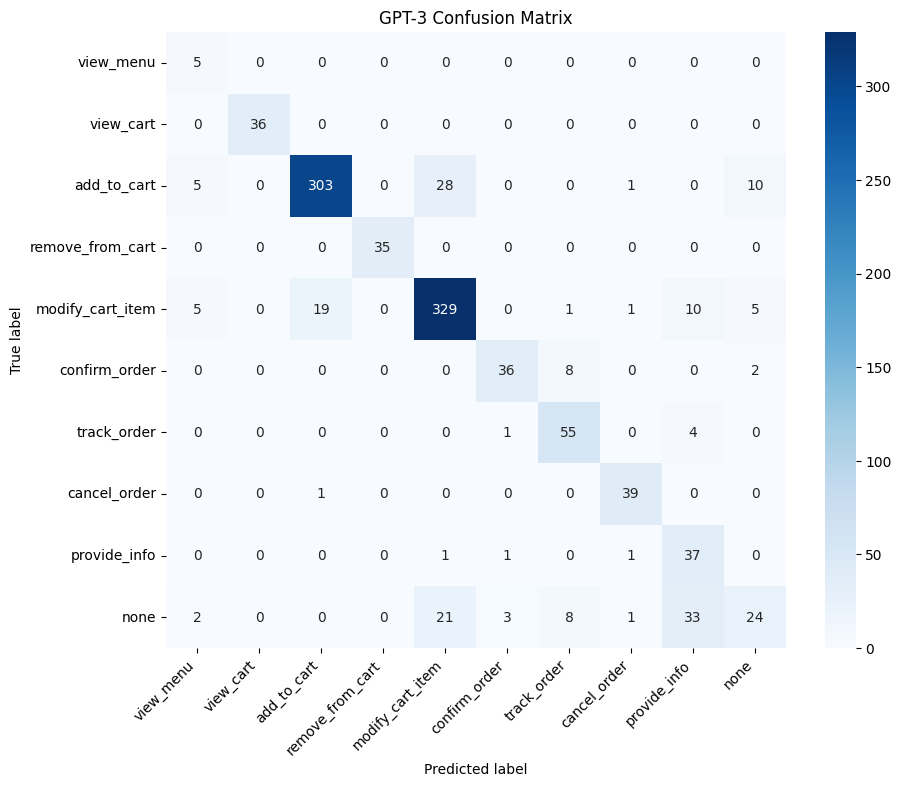

In [124]:
gpt3_preds = gpt3_labels.iloc[:, 1:].values

gpt3_pred_labels = np.argmax(gpt3_preds, axis=1)

true_label_ids = np.argmax(true_labels, axis=1)

cm = confusion_matrix(true_label_ids, gpt3_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

labels = compare_data.columns[1:]

plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0, va='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('GPT-3 Confusion Matrix')
plt.show()

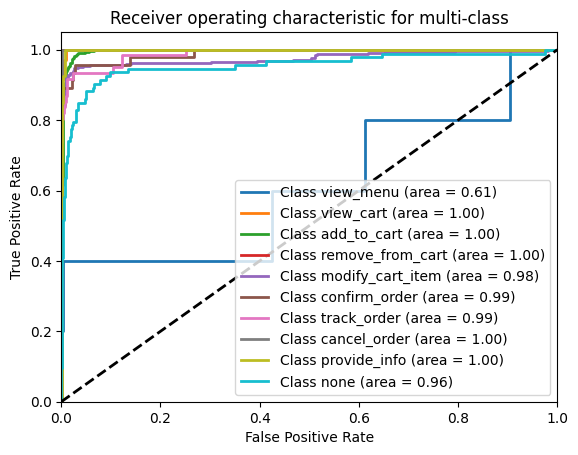

In [126]:
def plot_multiclass_roc_curve(target_values, prediction_probs, n_classes, class_labels):
    if not isinstance(target_values, np.ndarray):
        target_values = np.array(target_values)
    if not isinstance(prediction_probs, np.ndarray):
        prediction_probs = np.array(prediction_probs)
    
    lw = 2

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(target_values[:, i], prediction_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
                 label='Class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()

n_classes = target_values.shape[1]
class_labels = compare_data.columns[1:]

plot_multiclass_roc_curve(target_values, prediction_probs, n_classes, class_labels)